# Random Forest
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   str     1206 non-null   int64 
 1   hp      1206 non-null   int64 
 2   cha     1206 non-null   int64 
 3   con     1206 non-null   int64 
 4   int     1206 non-null   int64 
 5   book    1206 non-null   object
 6   wis     1206 non-null   int64 
 7   ac      1206 non-null   int64 
 8   dex     1206 non-null   int64 
 9   level   1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,str,hp,cha,con,int,book,wis,ac,dex,level
0,7,215,1,5,1,Pathfinder Bestiary,2,29,2,10
1,9,220,1,5,-4,Pathfinder Bestiary,2,28,0,10
2,7,175,-2,6,-4,Pathfinder Bestiary,3,25,3,8
3,7,315,6,5,6,Pathfinder Bestiary,5,41,4,17
4,-5,20,1,1,-1,Pathfinder Bestiary,1,16,3,1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


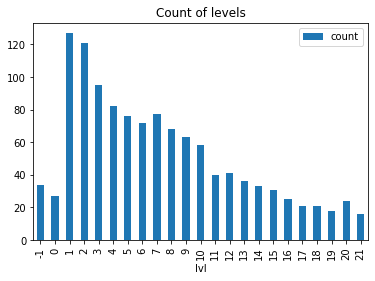

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/random_forest")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [10]:
X_train = X_train.astype("int64")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   str     841 non-null    int64
 1   hp      841 non-null    int64
 2   cha     841 non-null    int64
 3   con     841 non-null    int64
 4   int     841 non-null    int64
 5   wis     841 non-null    int64
 6   ac      841 non-null    int64
 7   dex     841 non-null    int64
dtypes: int64(8)
memory usage: 59.1 KB


In [11]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [12]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [13]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

## Chronological split

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [15]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 2.23
RMSE: 1.49
MAE: 1.19


In [17]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [18]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 1.22
RMSE test: 1.49


###### MAE by level

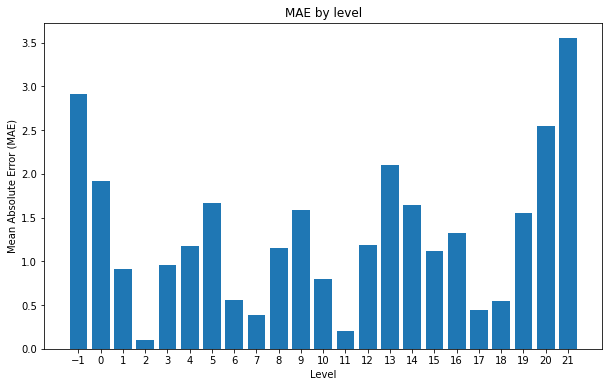

In [19]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [20]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.23
RMSE: 1.49

Round type: round
MSE: 2.52
RMSE: 1.59

Round type: 0.33
MSE: 2.16
RMSE: 1.47

Round type: 0.45
MSE: 2.52
RMSE: 1.59



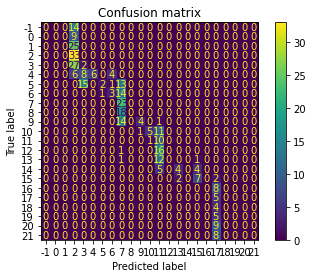

In [21]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [22]:
from training.results import assess_regression_model

In [23]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [24]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   2.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   2.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   2.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.0s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=70, max_features=0.5, n_

[CV] END ..max_depth=110, max_features=0.4, n_estimators=700; total time=   2.5s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.6s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.6s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.6s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.5s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.4s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.4s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=50, ma

[CV] END ...max_depth=20, max_features=0.4, n_estimators=500; total time=   0.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   1.1s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   1.1s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   1.0s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   1.2s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   1.1s
[CV] END ...max_depth=20, ma

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [25]:
rmse, mse, mae = assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.16
RMSE test: 0.68
MSE test: 0.46
MAE test: 0.43



In [26]:
results.loc[1] = [
    "chronological",
    "RandomizedSearchCV",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

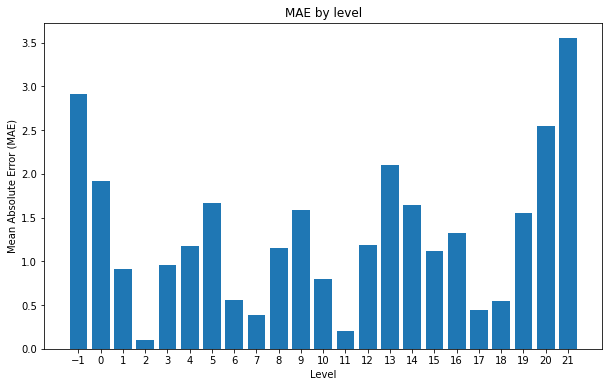

In [27]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [28]:
predict = rf_random.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.46
RMSE: 0.68

Round type: round
MSE: 0.52
RMSE: 0.72

Round type: 0.33
MSE: 0.47
RMSE: 0.69

Round type: 0.45
MSE: 0.47
RMSE: 0.69



### Attempt to decrease overfitting
Change max_depth to 7

In [29]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=100, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
rmse, mse, mae = assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.29
RMSE test: 0.69
MSE test: 0.48
MAE test: 0.46



In [30]:
results.loc[2] = [
    "chronological",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

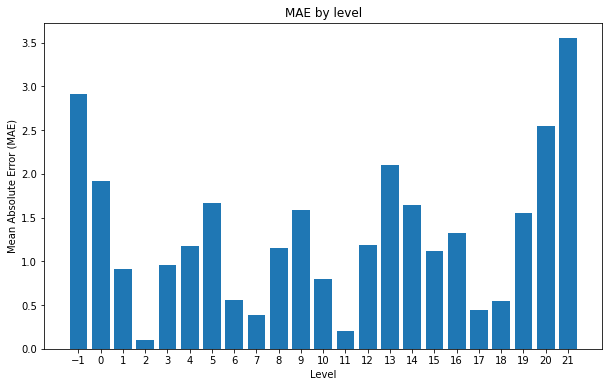

In [31]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

Check rounded predictions

In [32]:
predict = rf.predict(X_test)

check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.48
RMSE: 0.69

Round type: round
MSE: 0.53
RMSE: 0.73

Round type: 0.33
MSE: 0.47
RMSE: 0.69

Round type: 0.45
MSE: 0.53
RMSE: 0.73



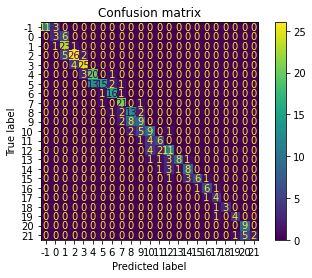

In [33]:
plot_confusion_matrix("round", predict, y_test)

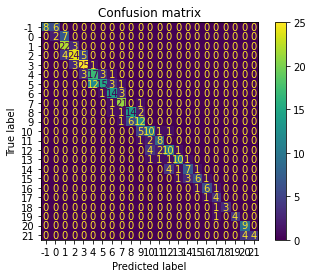

In [34]:
plot_confusion_matrix(0.33, predict, y_test)

The best results for threshold = 0.33

## Random split

In [35]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [36]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [37]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 1.67
RMSE: 1.29
MAE: 1.05


In [38]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

In [39]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

C:\Users\pauli\AppData\Local\Temp\ipykernel_22244\3659839605.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]


ValueError: Found input variables with inconsistent numbers of samples: [14, 12]

In [ ]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

In [ ]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

In [ ]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

In [ ]:
rmse, mse, mae = assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

In [ ]:
results.loc[4] = ["random", "RandomizedSearchCV", len(X_test.columns), mse, rmse, mae]

###### MAE by level

In [ ]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

### Attempt to decrease overfitting
Change max_depth to 13

In [ ]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=200, max_features=0.5, max_depth=13
)
rf.fit(X_train_random_split, y_train_random_split)
rmse, mse, mae = assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

In [ ]:
results.loc[5] = [
    "random",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

In [ ]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

Check rounded predictions

In [ ]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

In [ ]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

In [ ]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)

## Summary

In [ ]:
results

In [ ]:
from training.results import plot_summary

In [ ]:
plot_summary(results, "MSE")

In [ ]:
plot_summary(results, "RMSE")

In [ ]:
plot_summary(results, "MAE")

In [ ]:
results.to_json("./random_forest_basic_results.json")